# Imports

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import numpy as np
from tqdm import tqdm
import dask.dataframe as dd

mpl.style.use('default')
#%matplotlib notebook
%matplotlib inline

# Tensorflow backend initialization

In [3]:
"""
Setup multi GPU usage

Example usage:
model = Sequential()
...
multi_model = multi_gpu_model(model, gpus=num_gpu)
multi_model.fit()

About memory usage:
https://stackoverflow.com/questions/34199233/how-to-prevent-tensorflow-from-allocating-the-totality-of-a-gpu-memory
"""
import tensorflow as tf
from keras.utils.training_utils import multi_gpu_model
from tensorflow.python.client import device_lib

# IMPORTANT: Tells tf to not occupy a specific amount of memory
from keras.backend.tensorflow_backend import set_session  
config = tf.ConfigProto()  
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU  
sess = tf.Session(config=config)  
set_session(sess)  # set this TensorFlow session as the default session for Keras.


# getting the number of GPUs 
def get_available_gpus():
   local_device_protos = device_lib.list_local_devices()
   return [x.name for x in local_device_protos if x.device_type    == 'GPU']
num_gpu = len(get_available_gpus())
print('Amount of GPUs available: %s' % num_gpu)

/opt/jupyterhub/anaconda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
Using TensorFlow backend.


Amount of GPUs available: 4


# Function definitions

In [4]:
def reduce_memory(df):
    """
    Reduces memory footprint of the input dataframe.
    Changes float64 columns to float32 dtype.
    """
    columns = df.columns
    memory_before = df.memory_usage(deep=False).sum() / 2**30 # convert bytes to GB

    for column in tqdm(columns):
        if df[column].dtype == 'float64':
            df[column] = df[column].astype('float32')
        
    memory_after = df.memory_usage(deep=False).sum() / 2**30 # convert bytes to GB
    print('Memory uasge reduced from %.3f GB to %.3f GB' % (memory_before, memory_after))
    
    return df

# Preparing dataframe for preprocessing

In [14]:
%%time
df = pd.read_csv('//datc//opschaler//combined_gas_smart_weather_dfs//processed//all_dwellings_combined_10s.csv', delimiter='\t', parse_dates=['datetime'])
df = df.set_index(['datetime'])
df = df.dropna()

CPU times: user 2min 7s, sys: 26.3 s, total: 2min 33s
Wall time: 2min 23s


In [22]:
%%time
day = df.resample('1D').mean()
day = day.dropna()

CPU times: user 10.8 s, sys: 7.22 s, total: 18 s
Wall time: 16.8 s


# EDA

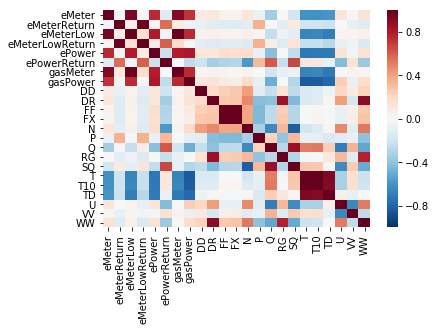

In [23]:
sns.heatmap(day.corr())

Text(0.5,0,'gasPower')

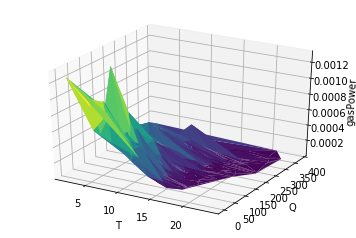

In [24]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_trisurf(day['T'], day['Q'], day['gasPower'], cmap=plt.cm.viridis, linewidth=0.2, antialiased=True)

ax.set_xlabel('T')
ax.set_ylabel('Q')
ax.set_zlabel('gasPower')

# Preprocessing

In [365]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

data = day[day['T'] < 19]

scaler = StandardScaler()

# Split predictors from targets
X = data.drop(['eMeter', 'eMeterReturn', 'eMeterLow', 'eMeterLowReturn', 'gasMeter','gasPower','ePowerReturn', 'WW', 'VV', 'P', 'DR', 'SQ', 'TD', 'T10', 'FX'], axis=1)

In [366]:
print('X columns: %s' % list(X.columns))
y = data[['gasPower']]

# Need to reshape X for cnn
print('Original X shape: '+str(X.shape))
#X = np.expand_dims(X, axis=2) # reshape for Conv1D, see https://stackoverflow.com/questions/43396572/dimension-of-shape-in-conv1d
print('New X shape: '+str(X.shape))

X = scaler.fit_transform(X)
y = scaler.fit_transform(y)

X columns: ['ePower', 'DD', 'FF', 'N', 'Q', 'RG', 'T', 'U']
Original X shape: (241, 8)
New X shape: (241, 8)


In [367]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)
print('')
print('X_train variance', X_train.var())
print('y_train variance', y_train.var())

X_train shape: (168, 8)
X_test shape: (73, 8)
y_train shape: (168, 1)
y_test shape: (73, 1)

X_train variance 0.988660218151
y_train variance 1.08245645408


# Create model in Keras

In [410]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers.recurrent import LSTM
from keras.layers import Dense, Conv1D, MaxPool2D, Flatten, Dropout
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam, SGD

# Dense

In [439]:
model = Sequential()

model.add(Dense(8*8, input_shape=(8,)))
model.add(Activation('relu'))
model.add(Dropout(0.2))

N = 32

for i in range(2):
    model.add(Dense(N))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))


model.add(Dense(1))
model.add(Activation('linear'))

# Compile and fit

In [ ]:
multi_model = multi_gpu_model(model, gpus=num_gpu)

lr = 0.1
epochs = 1000
decay_rate = lr/epochs

adam = Adam(lr=0.0001)
sgd = SGD(lr=lr, momentum=0.9, decay=decay_rate, nesterov=True) # Yields better results, but slower

# compiling the sequential model
multi_model.compile(loss='mean_squared_error', metrics=['mse'], optimizer='SGD')

early_stopping_monitor = EarlyStopping(patience=5000)

from livelossplot import PlotLossesKeras

# training the model and saving metrics in history
multi_model.fit(X_train, y_train, batch_size=int(len(X_train)), epochs=epochs, verbose=2, validation_data=(X_test, y_test), callbacks=[early_stopping_monitor, PlotLossesKeras()])

# CNN

Need to reshape X, scroll up.  
This one is not better than the Dense one...

model = Sequential()
model.add(Conv1D(16, 8, input_shape=(8,1,)))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Conv1D(4, 1))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Flatten()) # Flatten cnn output

N = 32

for i in range(2):
    model.add(Dense(N))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))

model.add(Dense(1))

# Visualize predictions

In [375]:
X_new = X_test # could use any ''new'' data
y_new = model.predict(X_new) # make predictions with X_new as input

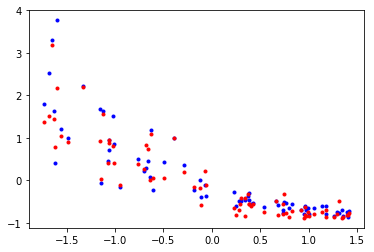

In [381]:
# X_new[:, 6] is the temperature column

x = X_new[:,6] # select temperature column

start = 0
stop = len(X_new)

plt.plot(x[start:stop], y_new[start:stop], '.', color='b')
plt.plot(x[start:stop], y_test[start:stop], '.', color='r')